<a href="https://colab.research.google.com/github/Git-Coder3112/CrashScope/blob/main/gnnbackend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-geometric


!pip install scikit-learn pandas numpy matplotlib seaborn


Found existing installation: torch_scatter 2.1.2+pt26cpu
Uninstalling torch_scatter-2.1.2+pt26cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt26cpu
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/torch_scatter-2.1.2%2Bpt26cpu-cp311-cp311-linux_x86_64.whl (545 kB)
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/torch_sparse-0.6.18%2Bpt26cpu-cp311-cp311-linux_x86_64.whl (1.1 MB)
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/torch_cluster-1.6.3%2Bpt26cpu-cp311-cp311-linux_x86_64.whl (781 kB)
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.6.0%2Bcpu/torch_spline_conv-1.2.2%2Bpt26cpu-cp311-cp311-linux_x86_64.whl (241 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cache

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from torch.optim import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer


In [ ]:
# Load dataset
file_path = '/content/Combined_Dataset_with_Severity_10k.csv'  # Change if needed
df = pd.read_csv(file_path)

# Show first few rows
df.head()


,Road Type,Road Class,Speed Limit,Area Type,Junction Location,Junction Control,Junction Detail,Carriageway,Hazards,Road Surface Conditions,Vehicle Type,Light Conditions,Weather Conditions,Severity Level
0,Urban,Primary,60,Rural,Not at or within 20 meters of junction,Stop sign,More than 4 arms (not roundabout),Carriageway,Vehicle load on road,Snow,Taxi cars,Darkness - lights lit,Other,Low
1,Rural,Residential,70,Rural,Not at or within 20 meters of junction,Stop sign,Roundabout,Carriageway,Other object on road,Dry,Other vehicle,Daylight,Rain - no high winds,Low
2,B Road,Country,70,Rural,Not at or within 20 meters of junction,Auto traffic signal,Slip road,Carriageway,Any animal in carriageway (except ridden horse),Frost or ice,Bus or coach (17 or more pass seats),Darkness - lighting unknown,Unknown,Low
3,Rural,Residential,70,Rural,Mid Junction - on roundabout or on main road,Give way or uncontrolled,Other junction,Carriageway,Other object on road,Frost or ice,Car,Darkness - lights unlit,Raining + high winds,Low
4,Rural,Residential,50,Rural,Mid Junction - on roundabout or on main road,Auto traffic signal,Private drive or entrance,Carriageway,Previous accident,Dry,Goods 7.5 tons mgw and over,Darkness - no lighting,Fine + high winds,Medium


In [ ]:
# Drop 'Carriageway' column if it exists
df.drop(columns=['Carriageway'], inplace=True, errors='ignore')

# Fill missing categorical values with the most frequent category
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with median
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)

print("Missing values handled successfully!")


Missing values handled successfully!


<ipython-input-4-645c49ccbe50>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-4-645c49ccbe50>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Categorical encoding completed!")


Categorical encoding completed!


In [ ]:
scaler = StandardScaler()
num_features = df.select_dtypes(include=['number']).columns.tolist()
df[num_features] = scaler.fit_transform(df[num_features])

print("Numerical features scaled!")


Numerical features scaled!


In [ ]:
X = df.drop(columns=['Severity Level'])
y = df['Severity Level']

X_values = X.values
y_values = y.values

print("Features and target prepared!")


Features and target prepared!


In [ ]:
k = 5  # Number of neighbors
adj_matrix = kneighbors_graph(X_values, k, mode="connectivity", include_self=True)

edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
x = torch.tensor(X_values, dtype=torch.float)
y = torch.tensor(y_values, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, y=y)

print("Graph construction successful!")


Graph construction successful!


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='GraphSAGE'):
        super(GNN, self).__init__()
        if model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(in_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, out_channels)
        elif model_type == 'GCN':
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        elif model_type == 'GAT':
            self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=False)
            self.conv2 = GATConv(hidden_channels, out_channels, heads=4, concat=False)
        else:
            raise ValueError("Invalid model type")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

print("GNN model defined!")


GNN model defined!


In [ ]:

if y.min() < 0:
    y = y - y.min()
graph_data.y = y.clone().detach().long()


In [ ]:

print("Unique target values in graph_data.y:", graph_data.y.unique())


Unique target values in graph_data.y: tensor([0, 1])


In [ ]:
!pip install pytorch-tabnet


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


🔥 Enhanced GraphSAGE model ready!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 - Loss: 5.7954 - Train Acc: 0.0014 - Test Acc: 0.0020
Epoch 10 - Loss: 3.7353 - Train Acc: 0.6841 - Test Acc: 0.6885
Epoch 20 - Loss: 2.5246 - Train Acc: 0.7221 - Test Acc: 0.7115
Epoch 30 - Loss: 1.6727 - Train Acc: 0.7971 - Test Acc: 0.7810
Epoch 40 - Loss: 1.0362 - Train Acc: 0.8778 - Test Acc: 0.8625
Epoch 50 - Loss: 0.6115 - Train Acc: 0.9293 - Test Acc: 0.9190
Epoch 60 - Loss: 0.3216 - Train Acc: 0.9606 - Test Acc: 0.9500
Epoch 70 - Loss: 0.1833 - Train Acc: 0.9736 - Test Acc: 0.9610
Epoch 80 - Loss: 0.1201 - Train Acc: 0.9795 - Test Acc: 0.9750
Epoch 90 - Loss: 0.0863 - Train Acc: 0.9876 - Test Acc: 0.9780
Epoch 100 - Loss: 0.0695 - Train Acc: 0.9884 - Test Acc: 0.9830
Epoch 110 - Loss: 0.0580 - Train Acc: 0.9915 - Test Acc: 0.9860
Epoch 120 - Loss: 0.0544 - Train Acc: 0.9909 - Test Acc: 0.9835
Epoch 130 - Loss: 0.0505 - Train Acc: 0.9924 - Test Acc: 0.9835
Epoch 140 - Loss: 0.0465 - Train Acc: 0.9930 - Test Acc: 0.9830
Epoch 150 - Loss: 0.0462 - Train Acc: 0.9935 - Test

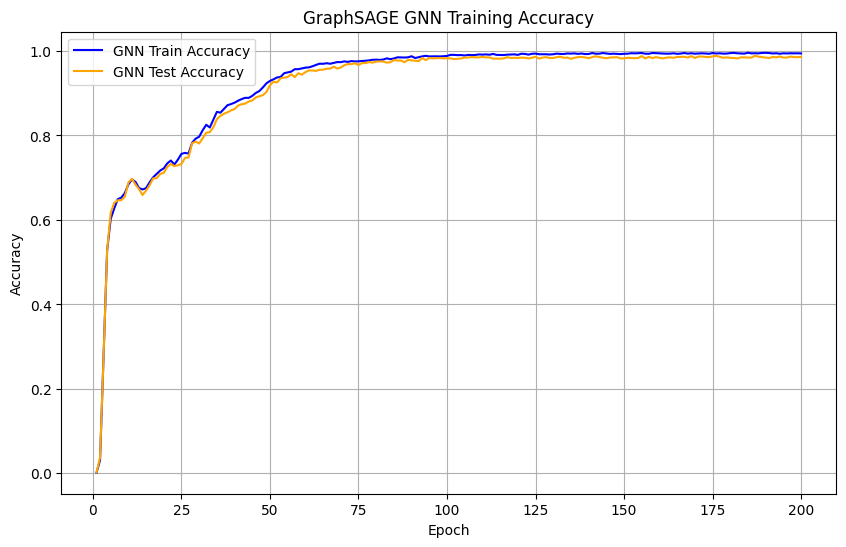

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Updated GraphSAGE with deeper layers and residual connection
class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super(GraphSAGEEncoder, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        return x

print("🔥 Enhanced GraphSAGE model ready!")

# Hyperparameters
hidden_size = 256
learning_rate = 0.1
num_epochs = 200

graph_data = graph_data.to(device)

# Split data
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42, stratify=graph_data.y.cpu())
train_mask = torch.tensor(train_idx, dtype=torch.long, device=device)
test_mask = torch.tensor(test_idx, dtype=torch.long, device=device)

# GNN Encoder
gnn_encoder = GraphSAGEEncoder(graph_data.x.shape[1], hidden_size).to(device)
optimizer = torch.optim.AdamW(gnn_encoder.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

gnn_train_acc = []
gnn_test_acc = []

for epoch in range(1, num_epochs + 1):
    gnn_encoder.train()
    optimizer.zero_grad()
    out = gnn_encoder(graph_data.x, graph_data.edge_index)
    loss = F.cross_entropy(out[train_mask], graph_data.y[train_mask])
    loss.backward()
    optimizer.step()

    gnn_encoder.eval()
    with torch.no_grad():
        preds = out.argmax(dim=1)
        train_acc = accuracy_score(graph_data.y[train_mask].cpu(), preds[train_mask].cpu())
        test_acc = accuracy_score(graph_data.y[test_mask].cpu(), preds[test_mask].cpu())
        gnn_train_acc.append(train_acc)
        gnn_test_acc.append(test_acc)
        scheduler.step(test_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

print("\n✅ GNN Training Done!")

# Extract embeddings
gnn_encoder.eval()
with torch.no_grad():
    gnn_embeddings = gnn_encoder(graph_data.x, graph_data.edge_index)

X = gnn_embeddings.cpu().numpy()
y = graph_data.y.cpu().numpy()
X_train, X_test = X[train_mask.cpu()], X[test_mask.cpu()]
y_train, y_test = y[train_mask.cpu()], y[test_mask.cpu()]


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("\n🌲 Training Random Forest with tuned params...\n" + "=" * 40)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=40,
    min_samples_split=3,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"\n📈 Final Accuracy (GraphSAGE + RF): {rf_acc:.4f}")

# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gnn_train_acc)+1), gnn_train_acc, label="GNN Train Accuracy", color='blue')
plt.plot(range(1, len(gnn_test_acc)+1), gnn_test_acc, label="GNN Test Accuracy", color='orange')
plt.title("GraphSAGE GNN Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

import joblib

torch.save(gnn_encoder.state_dict(), 'gnn_model.pth')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(rf, 'random_forest.pkl')

['random_forest.pkl']